<a href="https://colab.research.google.com/github/jhancuch/sba-loan-credit-analysis/blob/main/eda/eda_sba_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets and combine

In [119]:
data1 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/02e2e83a-2af1-4ce8-91db-85e20ffadbf7/download/foia-7afy2010-fy2019-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data2 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/02e2e83a-2af1-4ce8-91db-85e20ffadbf7/download/foia-7afy2010-fy2019-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data3 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/95d6972c-38df-4ecf-8f0a-eed224e8b02c/download/foia-7afy2000-fy2009-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data = pd.concat([data1, data2, data3], ignore_index=True).reset_index(drop=True)

In [120]:
# subset to observations with the LoanStatus PIF or CHGOFF aka paid in full or charged off. We don't care about loans that are currently being paid back
df = data[(data['LoanStatus'] == 'PIF') | (data['LoanStatus'] == 'CHGOFF')].reset_index(drop=True)

# convert PIF to 0 and CHGOFF to 1
df.loc[df['LoanStatus'] == 'PIF', 'LoanStatus'] = '0' 
df.loc[df['LoanStatus'] == 'CHGOFF', 'LoanStatus'] = '1'
df['LoanStatus'] = df['LoanStatus'].astype(int)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224831 entries, 0 to 1224830
Data columns (total 36 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   AsOfDate               1224831 non-null  int64  
 1   Program                1224831 non-null  object 
 2   BorrName               1224804 non-null  object 
 3   BorrStreet             1224810 non-null  object 
 4   BorrCity               1224820 non-null  object 
 5   BorrState              1224820 non-null  object 
 6   BorrZip                1224831 non-null  int64  
 7   BankName               1224831 non-null  object 
 8   BankStreet             1224793 non-null  object 
 9   BankCity               1224793 non-null  object 
 10  BankState              1224787 non-null  object 
 11  BankZip                1224793 non-null  object 
 12  GrossApproval          1224820 non-null  float64
 13  SBAGuaranteedApproval  1224820 non-null  float64
 14  ApprovalDate      

# Correlation EDA

## Loan Characteristics 

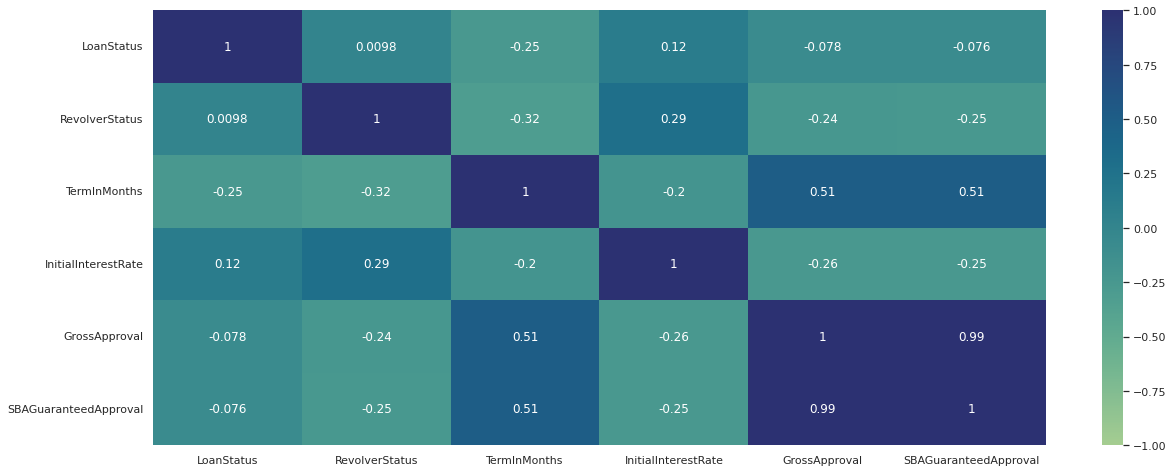

In [129]:
plt.figure(figsize=(20,8))
sns.heatmap(df[['LoanStatus', 'RevolverStatus', 'TermInMonths', 'InitialInterestRate', 'GrossApproval', 'SBAGuaranteedApproval']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [6]:
df_ProjectCounty = pd.get_dummies(df['ProjectCounty'], prefix = 'ProjectCounty_')

In [7]:
dependent_var = df[['LoanStatus']]

for i in range(0, len(df_ProjectCounty.columns), 200):
    end = i + 200
    results = df_ProjectCounty.iloc[:, i:end].merge(dependent_var, how='inner', left_index=True, right_index=True).corr().iloc[0, 1:].sort_values(ascending=False)
    print(results[0])
    print(results[-1])

0.0017282373938727325
-0.00027433364124977087
0.0038491763643353333
-0.0003082652021533479
-2.199846645519885e-05
-0.0036848839198786757
-9.427321635819198e-06
-0.0015791367081928423
-8.888150110746072e-06
-0.001488822027083497
-8.888150110746328e-06
-0.0014888220270834424
0.0041304040315815705
-0.0008161357352523896
-1.6628728819368064e-05
-0.0010312376170784705
-5.442815372603136e-06
-0.000911706408545304
0.003518530674345556
-0.0007601242636431209


## Company Characteristics

In [130]:
df['JobsDummy'] = 0
df.loc[df.JobsSupported > 0, 'JobsDummy'] = 1

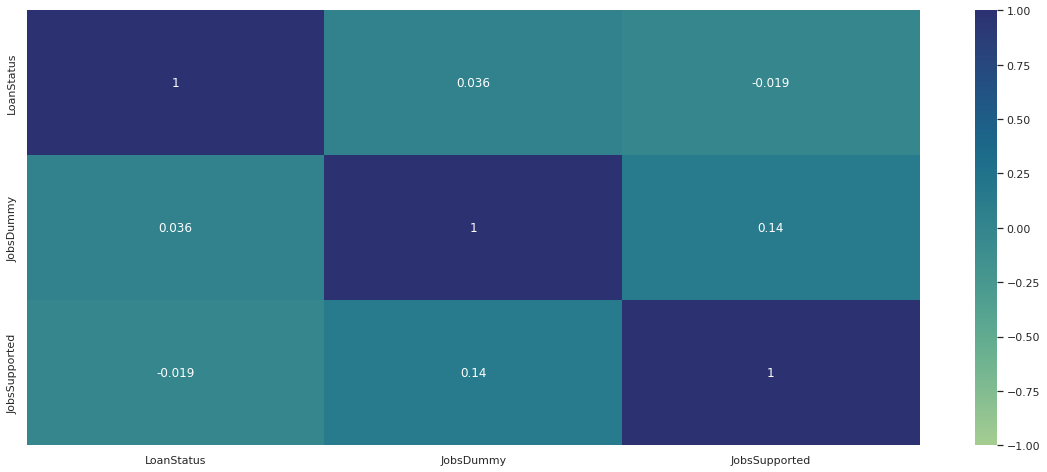

In [131]:
plt.figure(figsize=(20,8))
sns.heatmap(df[['LoanStatus', 'JobsDummy', 'JobsSupported']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [9]:
df_borrZips = pd.merge(df[['LoanStatus']], pd.get_dummies(df['BorrZip'], prefix = 'BorrZip_'), how='inner', left_index = True, right_index = True)

In [10]:
dependent_var = df[['LoanStatus']]

for i in range(0, len(df_borrZips.columns), 200):
    end = i + 200
    results = df_borrZips.iloc[:, i:end].merge(dependent_var, how='inner', left_index=True, right_index=True).corr().iloc[0, 1:].sort_values(ascending=False)
    print(results[0])
    print(results[-1])

1.0
-0.0032388945831462934
-3.142401045790955e-06
-0.00052637228631492
0.002632324845174813
-0.0003417782302139486
0.0030784299970856954
-0.00020413394106296776


KeyboardInterrupt: 

In [132]:
BorrNumLoansYear = df.groupby(['BorrName', 'ApprovalFiscalYear'])['BorrZip'].count().reset_index()
BorrNumLoansYear.rename(columns={'BorrZip':'BorrNumLoansYear'}, inplace=True)
df_BorrNumLoansYear = pd.merge(df, BorrNumLoansYear, how='left', on=['BorrName','ApprovalFiscalYear'])

In [133]:
df_BorrNumLoansYear[['LoanStatus', 'BorrNumLoansYear']].corr()

,LoanStatus,BorrNumLoansYear
LoanStatus,1.000000,-0.026808
BorrNumLoansYear,-0.026808,1.000000


In [134]:
BorrNumLoansTotal = df.groupby(['BorrName'])['BorrZip'].count().reset_index()
BorrNumLoansTotal.rename(columns={'BorrZip':'BorrNumLoansTotal'}, inplace=True)
df_BorrNumLoansTotal = pd.merge(df, BorrNumLoansTotal, how='left', on=['BorrName'])

In [135]:
df_BorrNumLoansTotal[['LoanStatus', 'BorrNumLoansTotal']].corr()

,LoanStatus,BorrNumLoansTotal
LoanStatus,1.000000,-0.011816
BorrNumLoansTotal,-0.011816,1.000000


In [136]:
df_DeliveryMethod = pd.merge(df[['LoanStatus']], pd.get_dummies(df['DeliveryMethod'], prefix = 'DeliveryMethod_'), how='inner', left_index = True, right_index = True)

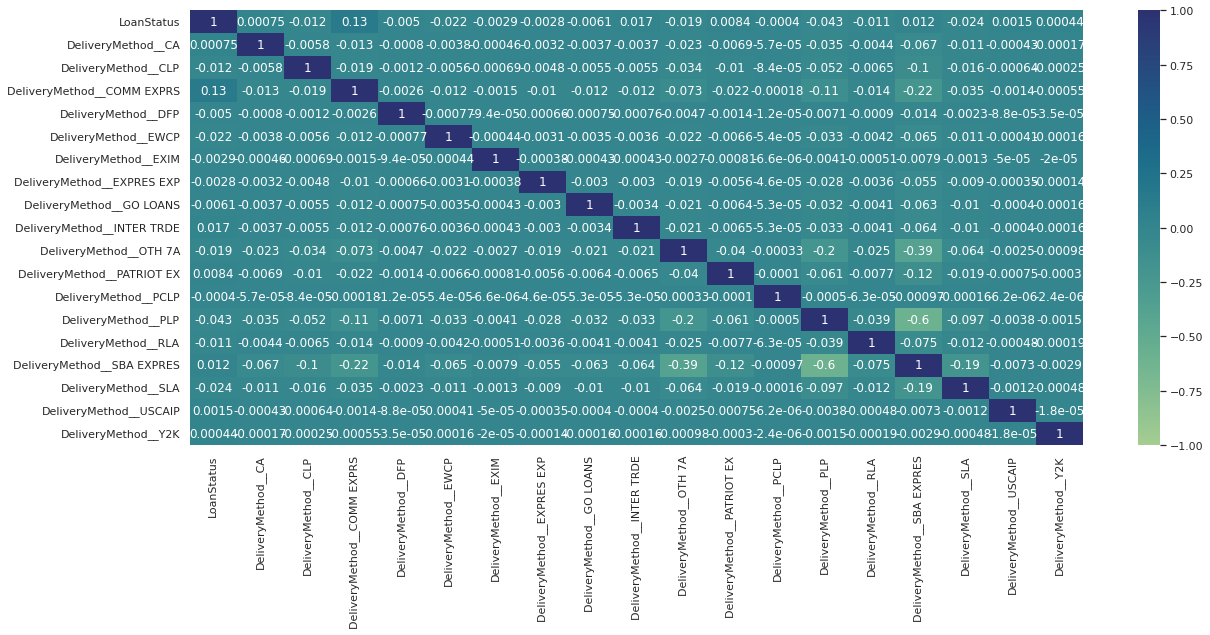

In [137]:
plt.figure(figsize=(20,8))
sns.heatmap(df_DeliveryMethod.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [138]:
df_subpgmdesc = pd.merge(df[['LoanStatus']], pd.get_dummies(df['subpgmdesc'], prefix = 'subpgmdesc_'), how='inner', left_index = True, right_index = True)

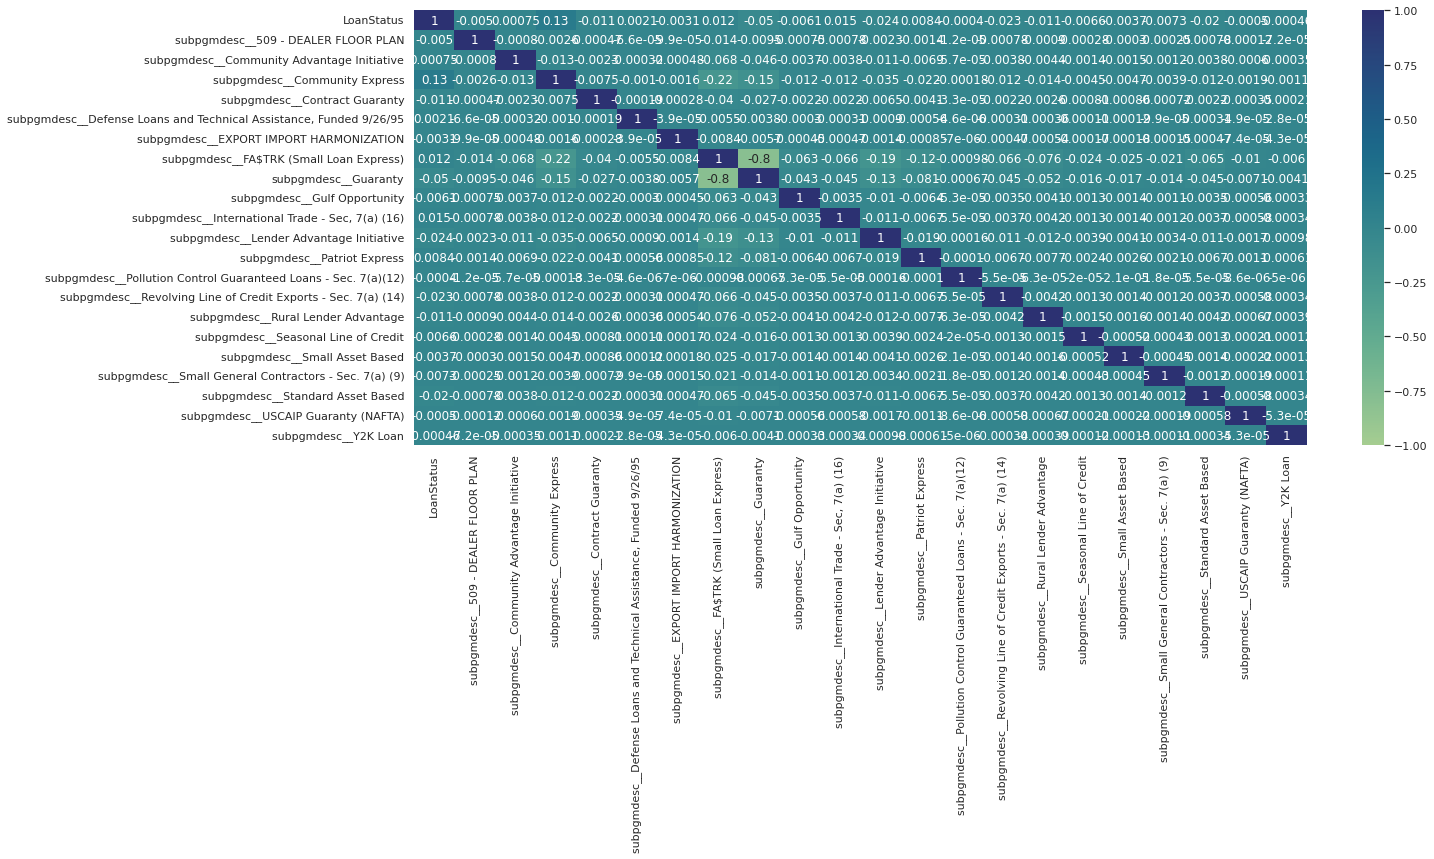

In [139]:
plt.figure(figsize=(20,8))
sns.heatmap(df_subpgmdesc.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [140]:
df_NaicsCode = df[['LoanStatus', 'NaicsCode']].copy().dropna()

df_NaicsCode['NaicsCode'] = df_NaicsCode['NaicsCode'].astype(str)
df_NaicsCode['NaicsCode'] = df_NaicsCode['NaicsCode'].str.slice(stop=2)
df_NaicsCode['NaicsCode'] = df_NaicsCode['NaicsCode'].astype(int)

df_NaicsCode = pd.merge(df_NaicsCode[['LoanStatus']], pd.get_dummies(df_NaicsCode['NaicsCode'], prefix = 'NaicsCode_'), how='inner', left_index = True, right_index = True) 

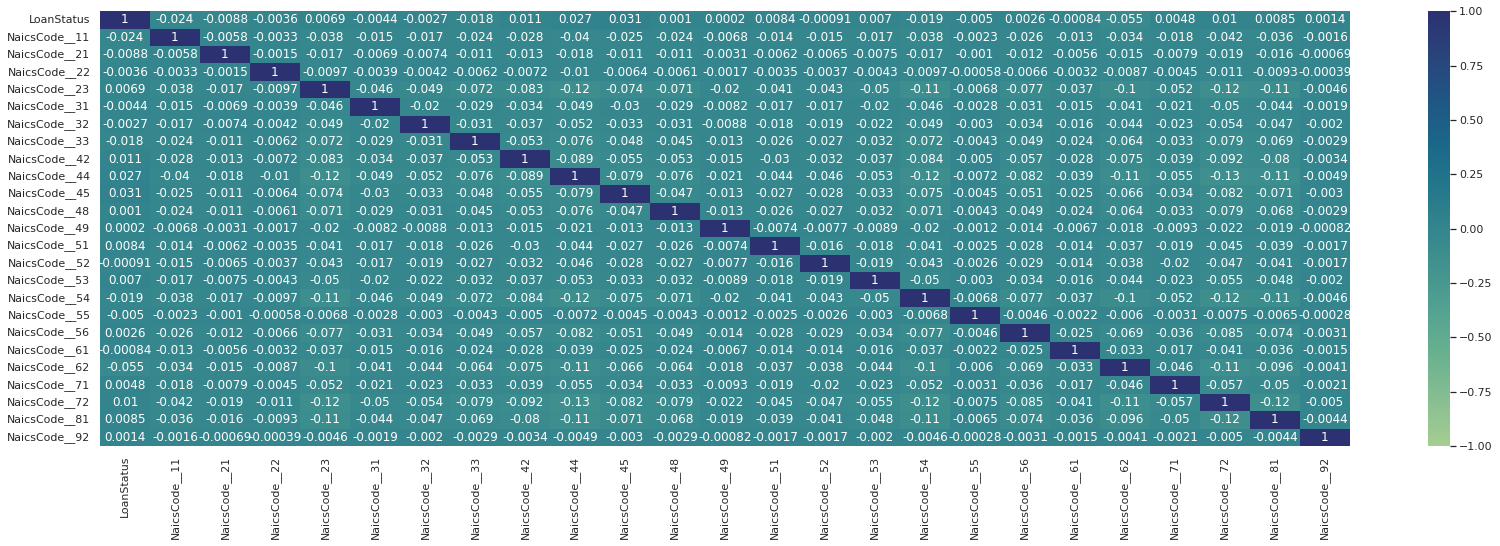

In [141]:
plt.figure(figsize=(28,8))
sns.heatmap(df_NaicsCode.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [142]:
df_FranchiseCode = df[['LoanStatus', 'FranchiseCode']].copy()
df_FranchiseCode.fillna('', inplace=True)

df_FranchiseCode['FranchiseCodeDummy'] = 0
df_FranchiseCode.loc[df_FranchiseCode.FranchiseCode != '', 'FranchiseCodeDummy'] = 1

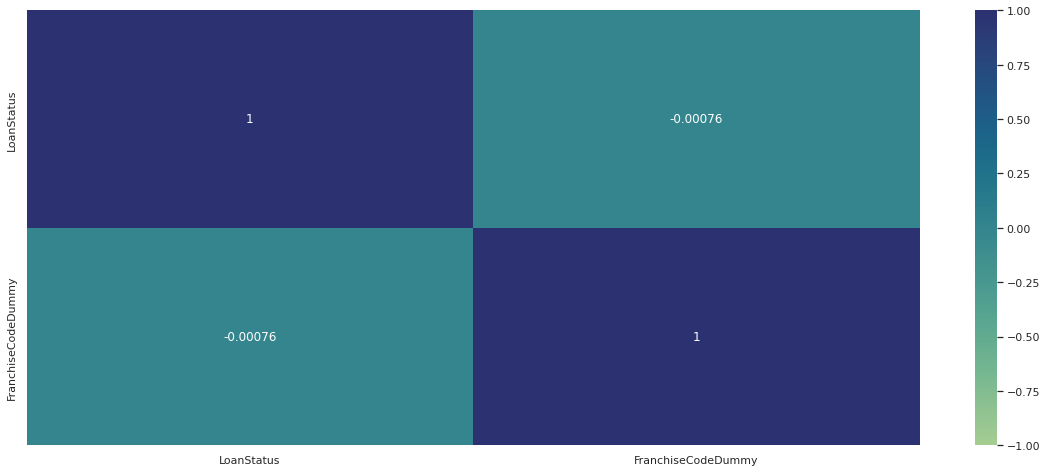

In [143]:
plt.figure(figsize=(20,8))
sns.heatmap(df_FranchiseCode[['LoanStatus', 'FranchiseCodeDummy']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [144]:
df_BusinessType = pd.merge(df[['LoanStatus']], pd.get_dummies(df['BusinessType'], prefix = 'BusinessType_'), how='inner', left_index = True, right_index = True)

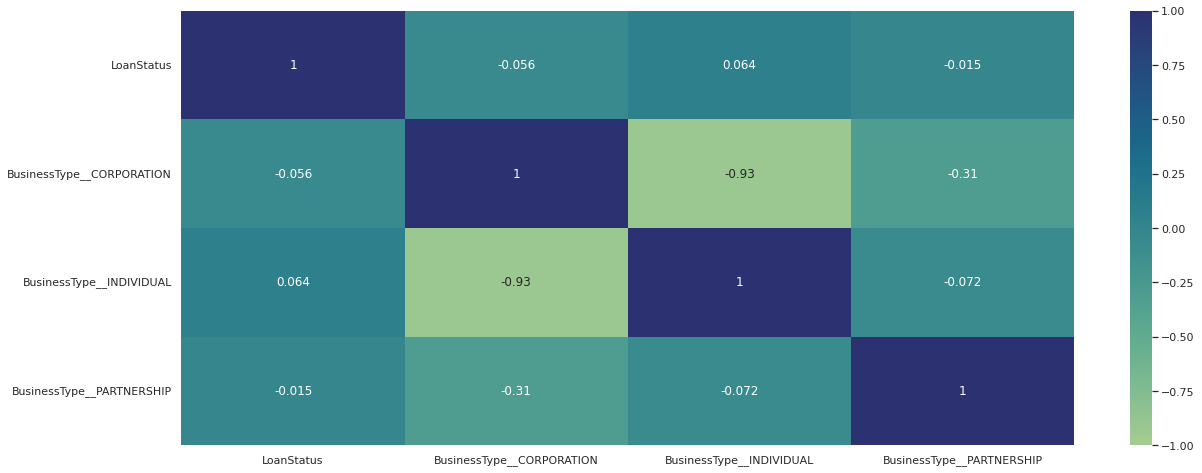

In [145]:
plt.figure(figsize=(20,8))
sns.heatmap(df_BusinessType.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

## Bank Characteristics

In [154]:
df_bank_zip = df[['LoanStatus', 'BorrZip', 'BankZip']].copy()

df_bank_zip['same'] = 0
df_bank_zip.loc[df_bank_zip.BankZip == df_bank_zip.BorrZip, 'same'] = 1

In [155]:
df_bank_zip

,LoanStatus,BorrZip,BankZip,same
0,0,75254,75070,0
1,0,80301,28403,0
2,0,52556,52556,0
3,0,30116,97470,0
4,0,80237,84133,0
...,...,...,...,...
1224826,0,49101,46360,0
1224827,0,28083,56301,0
1224828,0,1940,02110,0
1224829,0,92260,20429,0


In [156]:
df_bank_zip.same.value_counts()

0    1224831
Name: same, dtype: int64

In [157]:
df_bank_state = df[['LoanStatus', 'BorrState', 'BankState']].copy()

df_bank_state['same'] = 0
df_bank_state.loc[df_bank_state.BankState == df_bank_state.BorrState, 'same'] = 1

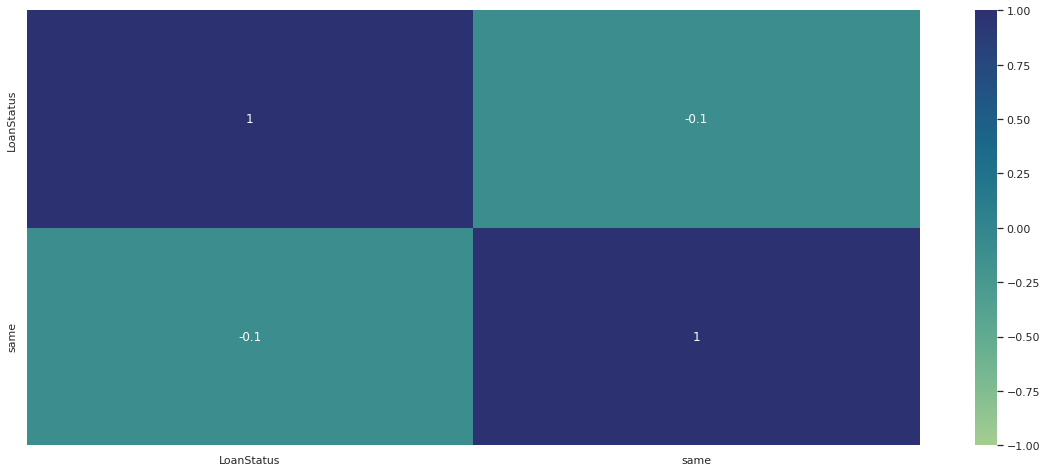

In [158]:
plt.figure(figsize=(20,8))
sns.heatmap(df_bank_state[['LoanStatus', 'same']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [159]:
df_BankName = pd.get_dummies(df['BankName'], prefix = 'BankName_')

KeyboardInterrupt: 

In [96]:
dependent_var = df[['LoanStatus']]

for i in range(0, len(df_BankName.columns), 200):
    end = i + 200
    results = df_BankName.iloc[:, i:end].merge(dependent_var, how='inner', left_index=True, right_index=True).corr().iloc[0, 1:].sort_values(ascending=False)
    print(results[0])
    print(results[-1])

-5.4428153726032315e-06
-0.0009117064085452863
-3.1424010457909103e-06
-0.0005263722863149112
-7.026666512302121e-06
-0.0011770116109803823
-3.142401045790912e-06
-0.0005263722863149111
-8.314090065777423e-06
-0.0013926632956074575
-7.69733959993378e-06
-0.0012893536454191348
-5.442815372602993e-06
-0.0009187483488533988
-1.29567771570626e-05
-0.0012232184284030696
-4.444033159845546e-06
-0.0007444039957727557
-3.0471161328889718e-05
-0.0030936962265673785
-4.2869099089751635e-05
-0.0019563219840100137
-2.685172411626007e-05
-0.004497835638612786
0.0045809983854290135
-0.0025026692591039435
-4.400709978295378e-05
-0.007053809616389668


In [160]:
BankNumLoansYear = df.groupby(['BankName', 'ApprovalFiscalYear'])['BankZip'].count().reset_index()
BankNumLoansYear.rename(columns={'BankZip':'BankNumLoansYear'}, inplace=True)
df_BankNumLoansYear = pd.merge(df, BankNumLoansYear, how='left', on=['BankName','ApprovalFiscalYear'])

In [161]:
df_BankNumLoansYear[['LoanStatus', 'BankNumLoansYear']].corr()

,LoanStatus,BankNumLoansYear
LoanStatus,1.000000,0.137507
BankNumLoansYear,0.137507,1.000000


In [162]:
BankNumLoansTotal = df.groupby(['BankName'])['BankZip'].count().reset_index()
BankNumLoansTotal.rename(columns={'BankZip':'BankNumLoansTotal'}, inplace=True)
df_BankNumLoansTotal = pd.merge(df, BankNumLoansTotal, how='left', on=['BankName'])

In [163]:
df_BankNumLoansTotal[['LoanStatus', 'BankNumLoansTotal']].corr()

,LoanStatus,BankNumLoansTotal
LoanStatus,1.000000,0.074606
BankNumLoansTotal,0.074606,1.000000


In [164]:
df_PctDefault = pd.merge(pd.DataFrame(df.groupby('BankName')['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'Count'}), 
                 pd.DataFrame(df.groupby('BankName')['LoanStatus'].sum()).reset_index(), 
                 how='inner', on='BankName')
df_PctDefault['PctDefault'] = df_PctDefault['LoanStatus']/df_PctDefault['Count']

In [165]:
df_PctDefault[['LoanStatus','PctDefault']].corr()

,LoanStatus,PctDefault
LoanStatus,1.000000,0.025809
PctDefault,0.025809,1.000000


In [166]:
df_BankLoansIssued = pd.DataFrame(df.groupby('BankName')['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'LoanCounts'})
df_BankLoansIssued = pd.merge(df, df_BankLoansIssued, how='left', on=['BankName'])

In [167]:
df_BankLoansIssued[['LoanStatus', 'LoanCounts']].corr()

,LoanStatus,LoanCounts
LoanStatus,1.000000,0.074606
LoanCounts,0.074606,1.000000


In [168]:
df_BankDefaults = pd.merge(pd.DataFrame(df.groupby('BankName')['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'LoanCounts'}), 
                           pd.DataFrame(df.groupby('BankName')['LoanStatus'].sum()).reset_index().rename(columns={'LoanStatus':'DefaultCounts'}), 
                           how='inner', on='BankName')
df_BankDefaults = pd.merge(df[['LoanStatus', 'BankName']], df_BankDefaults, how='inner', on='BankName')
df_BankDefaults['PctDefault'] = df_BankDefaults['DefaultCounts']/df_BankDefaults['LoanCounts']

In [169]:
df_BankDefaults[['LoanStatus', 'DefaultCounts']].corr()

,LoanStatus,DefaultCounts
LoanStatus,1.000000,0.134514
DefaultCounts,0.134514,1.000000


In [170]:
df_BankDefaults[['LoanStatus', 'PctDefault']].corr()

,LoanStatus,PctDefault
LoanStatus,1.000000,0.265272
PctDefault,0.265272,1.000000


## Feature Engineering

In [ ]:
# age of the loan, as the loan is held on longer, more odds to default - look at the length of payed back loans and defaulted loans ChargeOffDate/PaidInFullDate and FirstDisbursementDate
# should look at bank default cumalitive to year prior. So for a loan in 2015, consider 2010-2014 cumaltive default rate
# dummy variables for fiscal approval date
# try three digit zips - need to pad and then take the first three

In [171]:
df_Year = pd.merge(df[['LoanStatus']], pd.get_dummies(df['ApprovalFiscalYear'], prefix = 'ApprovalFiscalYear_'), how='inner', left_index = True, right_index = True)

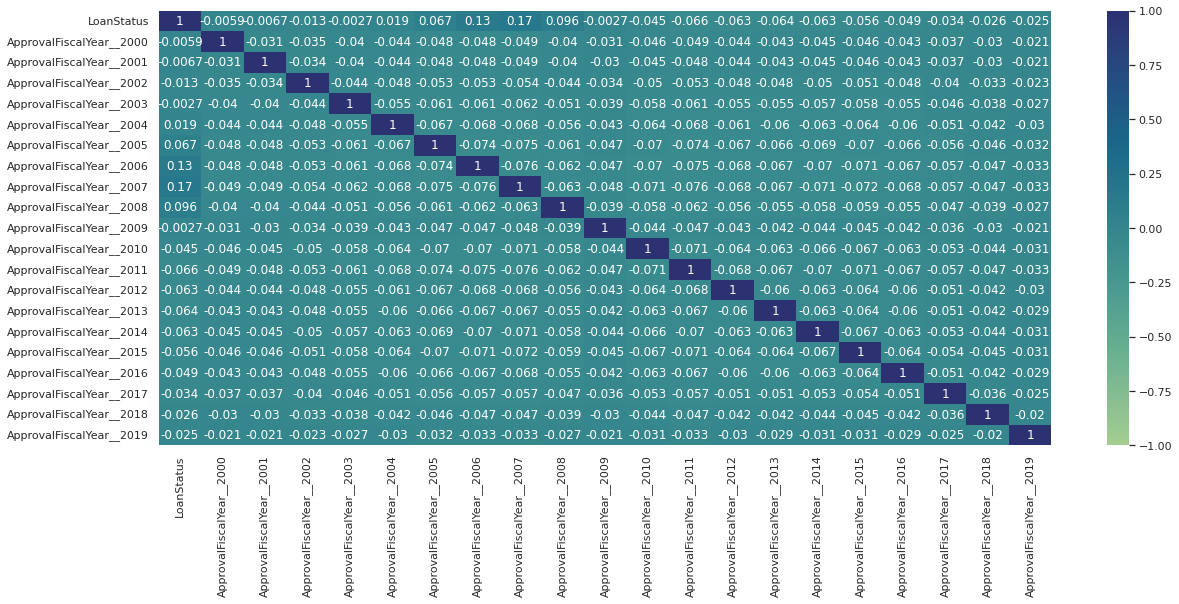

In [172]:
plt.figure(figsize=(20,8))
sns.heatmap(df_Year.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [173]:
df[['ChargeOffDate', 'PaidInFullDate', 'FirstDisbursementDate']]

,ChargeOffDate,PaidInFullDate,FirstDisbursementDate
0,NaN,11/30/2015,10/01/2009
1,NaN,10/31/2018,01/01/2010
2,NaN,02/29/2012,10/01/2009
3,NaN,09/30/2014,10/01/2009
4,NaN,10/31/2016,10/01/2009
...,...,...,...
1224826,NaN,07/31/2013,02/01/2010
1224827,NaN,03/31/2014,10/01/2009
1224828,NaN,05/31/2018,12/01/2009
1224829,NaN,11/30/2010,10/01/2009


In [ ]:
df_Length = df[['ChargeOffDate', 'PaidInFullDate', 'FirstDisbursementDate']].copy()

df_Length = df_Length[df_Length['FirstDisbursementDate'].notna()]

df_Length['Initial'] = df_Length['FirstDisbursementDate'].str.slice(start=6)
df_Length['Initial'] = df_Length['Initial'].astype(int)

df_Length['Final'] = df_Length['PaidInFullDate']
df_Length.loc[pd.isna(df_Length['Final']), 'Final'] = df_Length['ChargeOffDate']

df_Length = df_Length[df_Length['Final'].notna()]

df_Length['Final'] = df_Length['Final'].str.slice(start=6)
df_Length['Final'] = df_Length['Final'].astype(int)

df_Length['Length'] = df_Length['Final'] - df_Length['Initial']

df_Length = pd.merge(df[['LoanStatus', 'ChargeOffDate', 'PaidInFullDate', 'FirstDisbursementDate']], df_Length, how='inner', on=['ChargeOffDate', 'PaidInFullDate', 'FirstDisbursementDate'])

In [ ]:
len(df_Length)

In [ ]:
len(df_Length.drop_duplicates())

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318229 entries, 0 to 318228
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AsOfDate               318229 non-null  int64  
 1   Program                318229 non-null  object 
 2   BorrName               318218 non-null  object 
 3   BorrStreet             318229 non-null  object 
 4   BorrCity               318229 non-null  object 
 5   BorrState              318229 non-null  object 
 6   BorrZip                318229 non-null  int64  
 7   BankName               318229 non-null  object 
 8   BankStreet             318228 non-null  object 
 9   BankCity               318228 non-null  object 
 10  BankState              318228 non-null  object 
 11  BankZip                318228 non-null  object 
 12  GrossApproval          318229 non-null  float64
 13  SBAGuaranteedApproval  318229 non-null  float64
 14  ApprovalDate           318229 non-nu